# Pacific Section: Triple Decomp Analysis

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
from xhistogram.xarray import histogram
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

# Load Data

In [3]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-180,-175)_lat:(-70,70)_ds_z.nc')

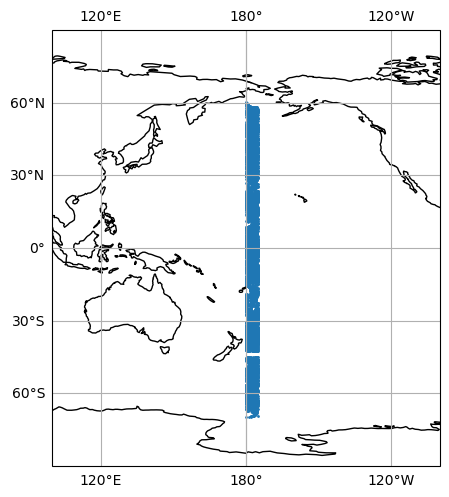

In [4]:
fig = plt.figure(figsize=(5, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
ax.set_global()
ax.set_extent([100, -100, -90, 90])
ax.gridlines(draw_labels=True)

ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=1)

In [5]:
x='LATITUDE'
y='PRES_INTERPOLATED'
sample_max = 2.5

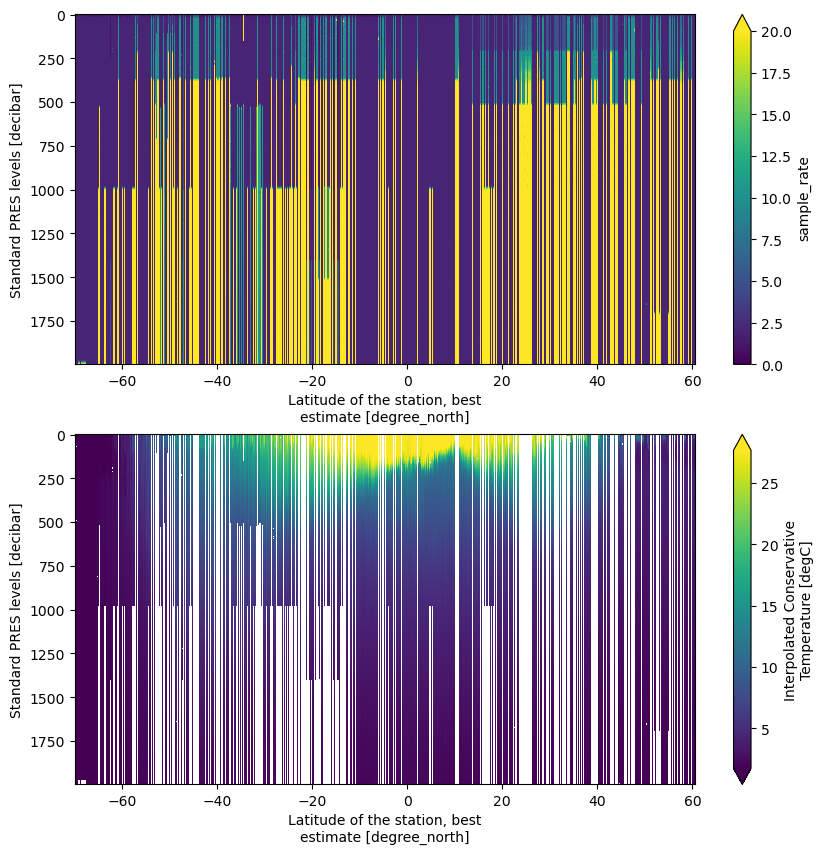

In [6]:
plt.figure(figsize=(10,10))

plt.subplot(211)
ds.sortby(x).sample_rate.plot(x=x,y=y,vmin=0,vmax=20)
plt.gca().invert_yaxis()

plt.subplot(212)
ds.sortby(x).CT.where(ds.sample_rate<sample_max).plot(x=x,y=y,robust=True)
plt.gca().invert_yaxis()

# Calculate Terms

In [7]:
lfilt = 100

ct_b = ds.CT
sa_b = ds.SA

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds, lfilt, 'SA')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m

In [8]:
K_rho4 = 10**(-4)
K_rho5 = 10**(-5)
K_rho6 = 10**(-6)

In [9]:
ct_2 = K_rho5*ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)
sa_2 = K_rho5*ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)

ct_3 = K_rho5*(ct_m.differentiate(coord='PRES_INTERPOLATED'))**2
sa_3 = K_rho5*(sa_m.differentiate(coord='PRES_INTERPOLATED'))**2

Text(0.5, 1.0, 'Mean SA Variance')

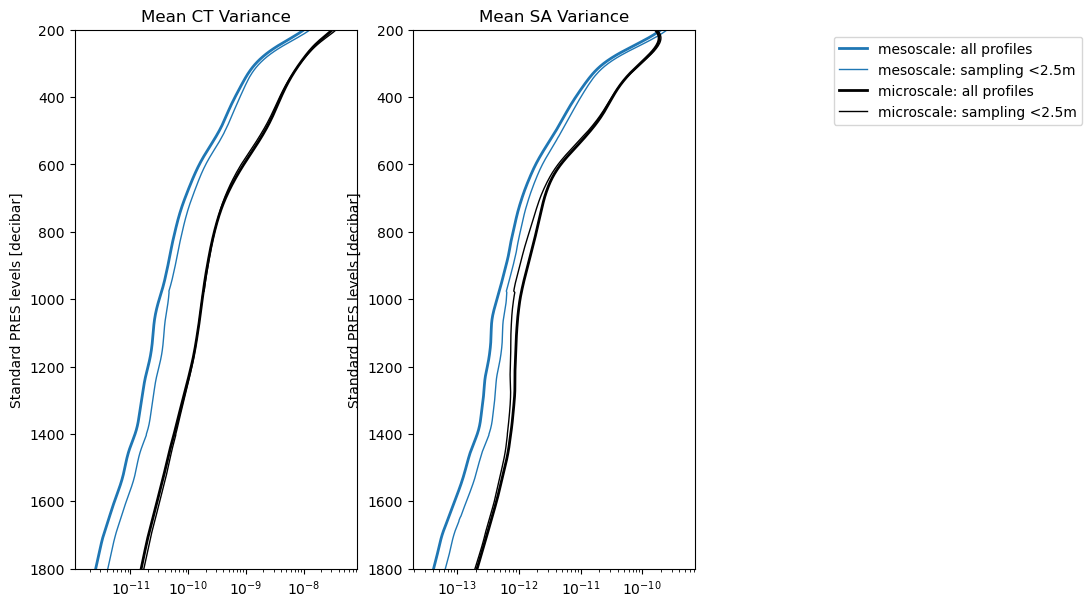

In [10]:
plt.figure(figsize=(8,7))

plt.subplot(121)
ct_2.mean('N_PROF').plot(y='PRES_INTERPOLATED',linewidth=2,label='mesoscale: all profiles')
ct_2.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='tab:blue',linewidth=1,label='mesoscale: sampling <2.5m')
ct_3.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=2, label='microscale: all profiles')
ct_3.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=1, label='microscale: sampling <2.5m')
plt.xscale('log')
plt.legend(bbox_to_anchor=(3.6,1))
plt.ylim(1800,200)
plt.title('Mean CT Variance')

plt.subplot(122)
sa_2.mean('N_PROF').plot(y='PRES_INTERPOLATED',linewidth=2)
sa_2.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='tab:blue',linewidth=1)
sa_3.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=2)
sa_3.where(ds.sample_rate<sample_max).mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth=1)
plt.xscale('log')
plt.ylim(1800,200)
plt.title('Mean SA Variance')

# Variance Section

In [11]:
ct_start = 10**-14
ct_end   = 10**-7
ct_norm  = colors.LogNorm(vmin=ct_start, vmax=ct_end)
ct_cmap  = cmo.matter_r

In [12]:
levels = [26,27,27.2,27.3,27.72]
lat_bins = np.arange(-70,70,2)
SIG0_binned = ds.SIG0.groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
ct_binned   = ds.CT.where(ct_2.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
ct_2_binned = ct_2 .where(ct_2.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
ct_3_binned = ct_3 .where(ct_3.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')

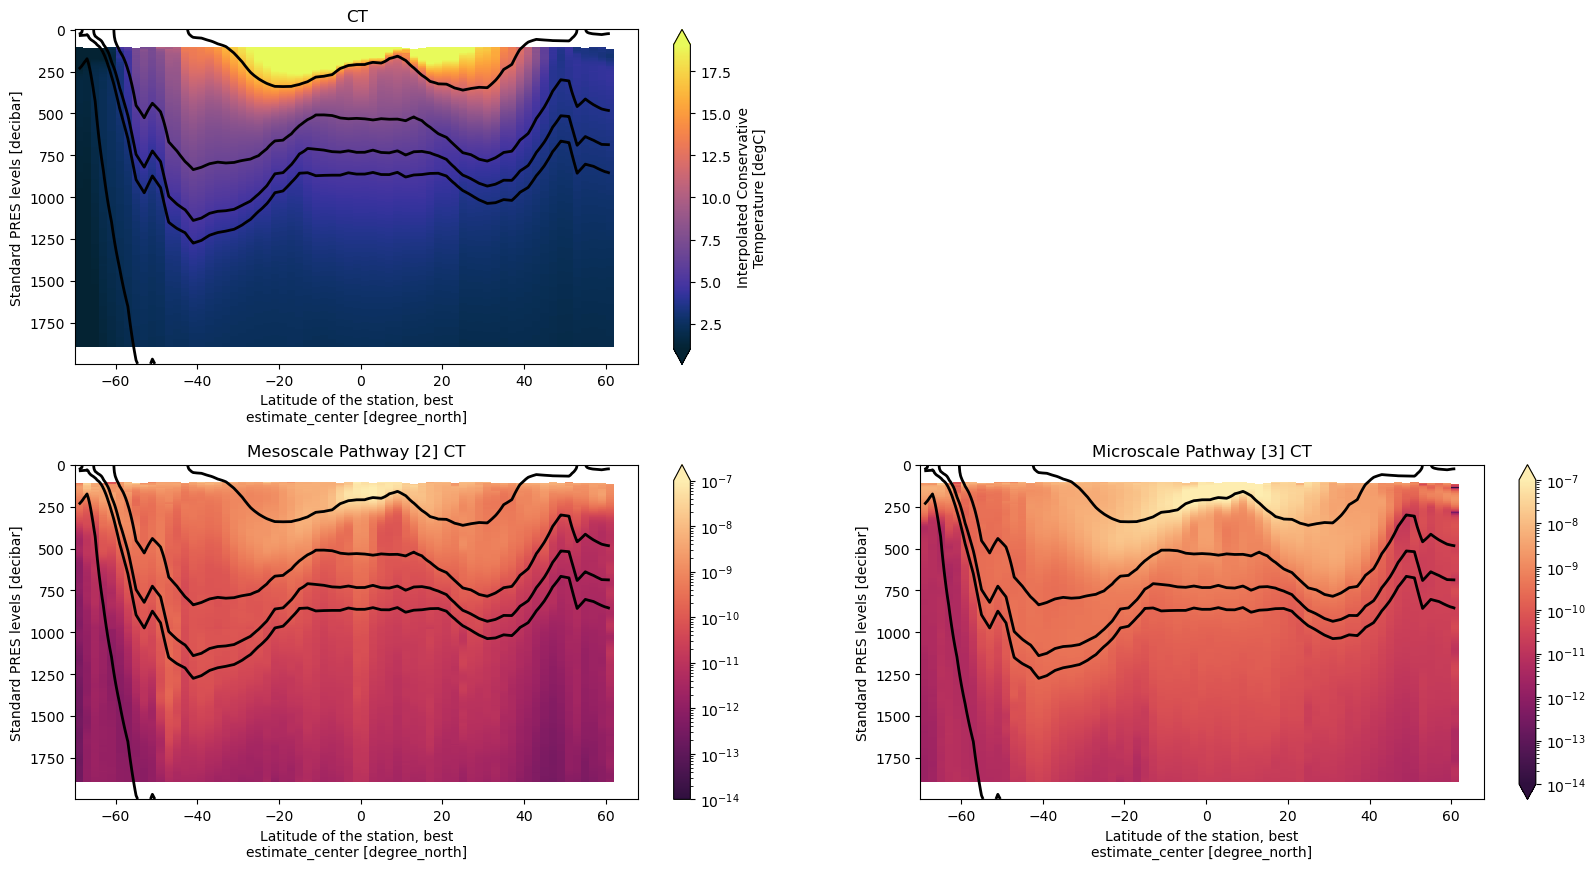

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ct_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.thermal, robust=True)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(223)
ct_2_binned.plot(x='LATITUDE_bins', y=y, norm=ct_norm, cmap=ct_cmap)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('Mesoscale Pathway [2] CT')

plt.subplot(224)
ct_3_binned.plot(x='LATITUDE_bins', y=y, norm=ct_norm, cmap=ct_cmap)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('Microscale Pathway [3] CT')

plt.subplots_adjust(hspace=0.3)

In [14]:
sa_start = 10**-15
sa_end   = 10**-9
sa_norm  = colors.LogNorm(vmin=sa_start, vmax=sa_end)
sa_cmap  = cmo.matter_r

In [20]:
sa_binned   = ds.SA.where(sa_2.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
sa_2_binned = sa_2.where(sa_2.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
sa_3_binned = sa_3.where(sa_3.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')

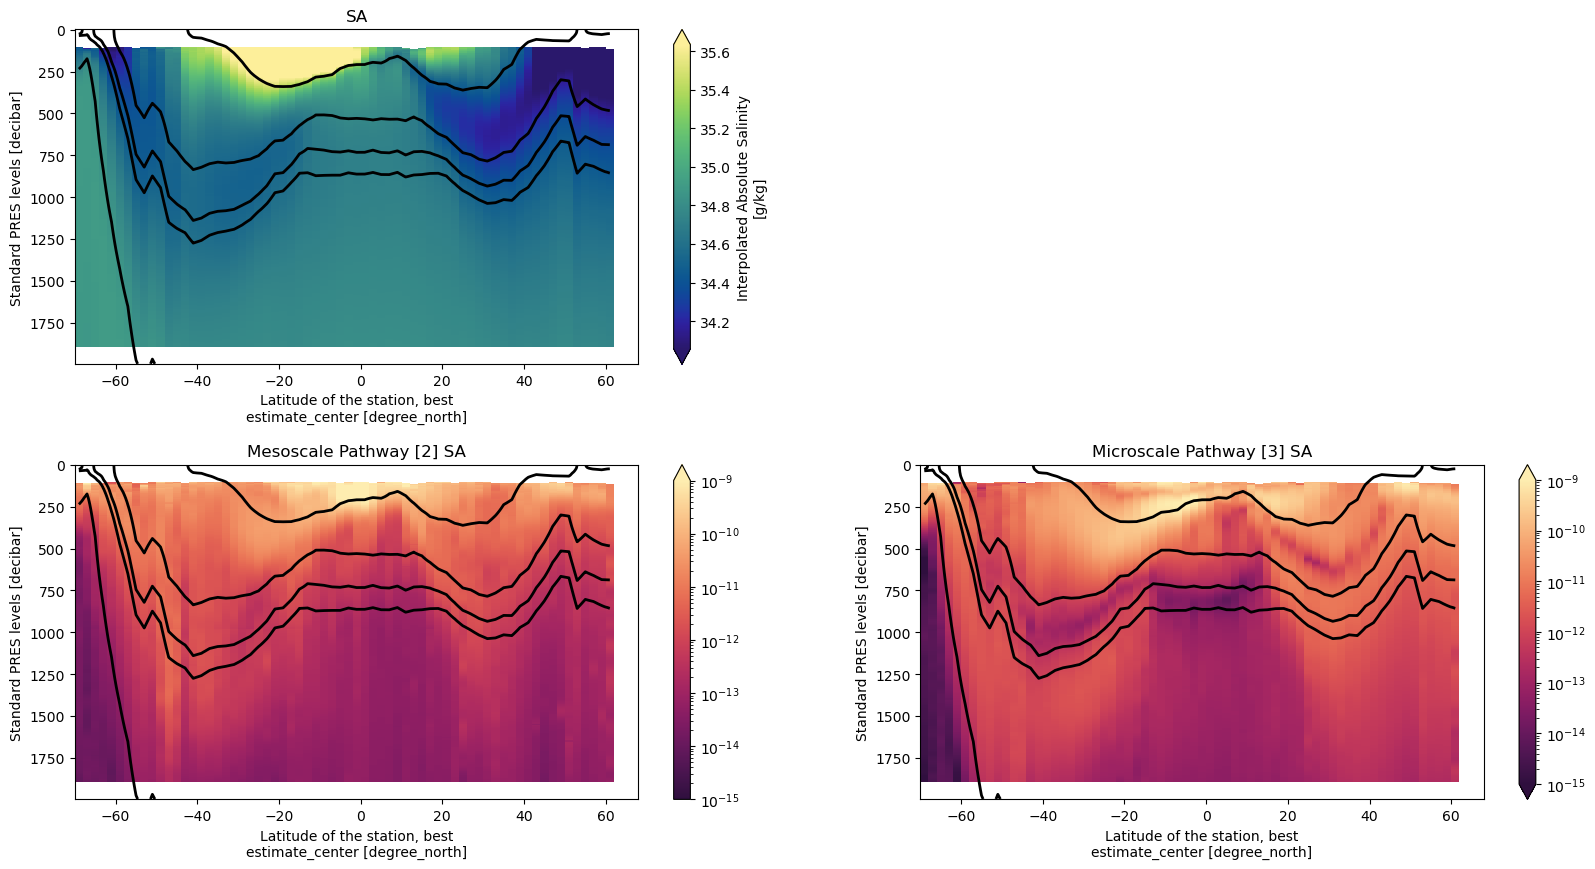

In [21]:
x='LATITUDE'
y='PRES_INTERPOLATED'

plt.figure(figsize=(20,10))

plt.subplot(221)
sa_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.haline, robust=True)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(223)
sa_2_binned.plot(x='LATITUDE_bins', y=y, norm=sa_norm, cmap=sa_cmap)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('Mesoscale Pathway [2] SA')

plt.subplot(224)
sa_3_binned.plot(x='LATITUDE_bins', y=y, norm=sa_norm, cmap=sa_cmap)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('Microscale Pathway [3] SA')

plt.subplots_adjust(hspace=0.3)

# Ratio Sections

In [22]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

In [23]:
ctrat_start = 10**-11
ctrat_end   = 10**-8
ctrat_norm  = colors.LogNorm(vmin=ctrat_start, vmax=ctrat_end)
rat_cmap  = cmo.matter_r

In [24]:
ct_tot_binned  = ct_tot.where(ct_tot.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
ct_2rat_binned = ct_2rat.where(ct_2rat.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
ct_3rat_binned = ct_3rat.where(ct_3rat.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')

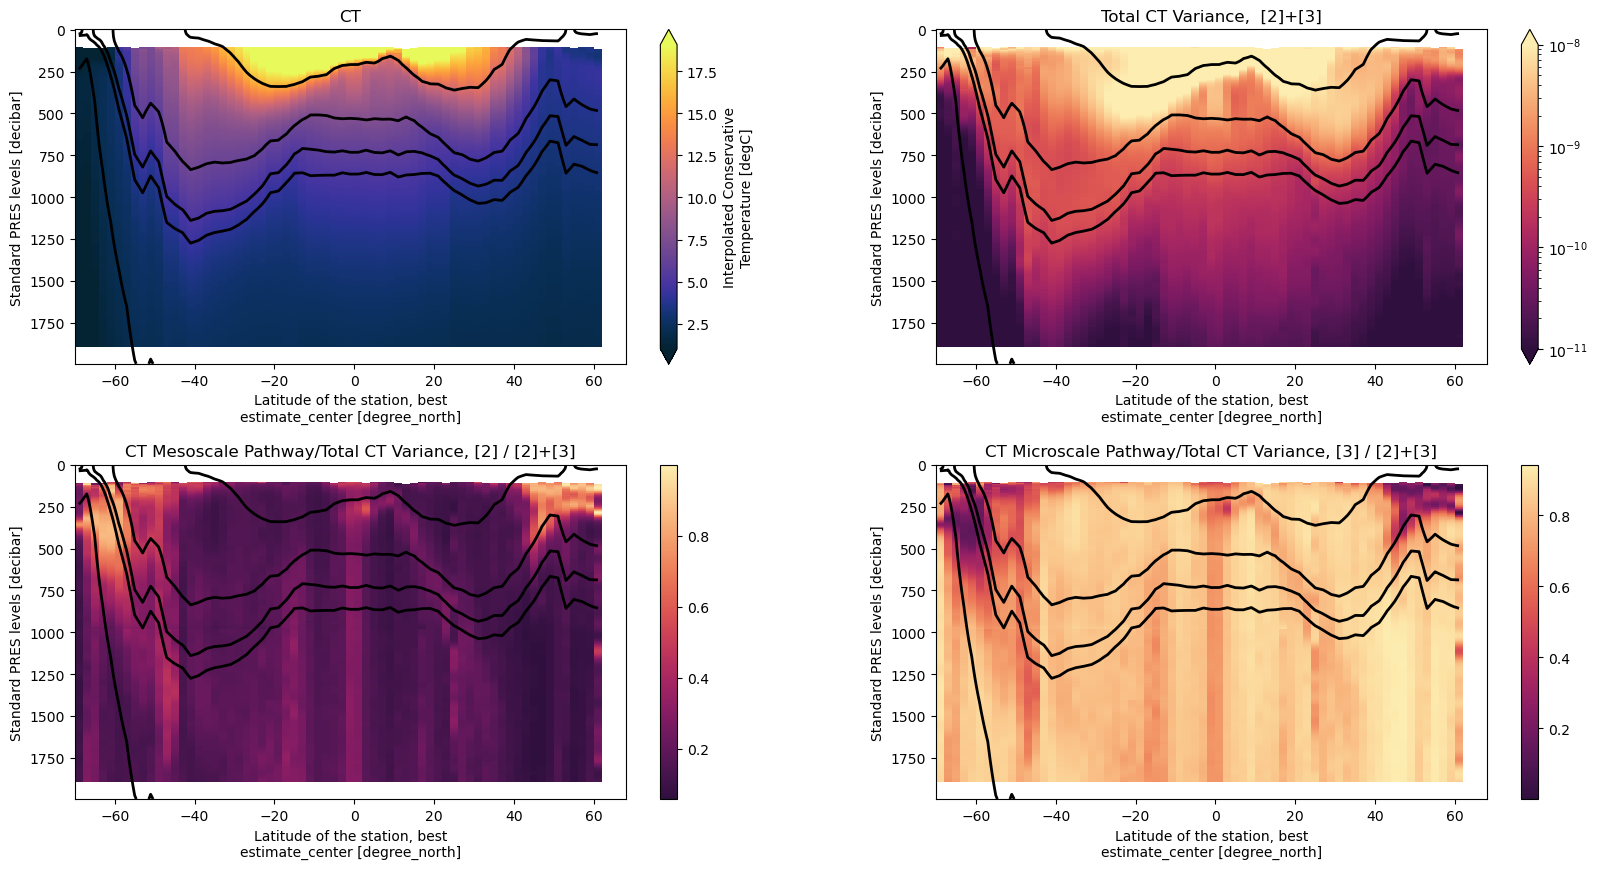

In [25]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ct_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.thermal, robust=True)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(222)
ct_tot_binned.plot(x='LATITUDE_bins', y=y, norm=ctrat_norm, cmap=rat_cmap)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('Total CT Variance,  [2]+[3]')

plt.subplot(223)
ct_2rat_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.matter_r)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('CT Mesoscale Pathway/Total CT Variance, [2] / [2]+[3]')

plt.subplot(224)
ct_3rat_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.matter_r)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('CT Microscale Pathway/Total CT Variance, [3] / [2]+[3]')

plt.subplots_adjust(hspace=0.3, wspace=0.25)

In [26]:
sarat_start = 10**-13
sarat_end   = 10**-9
sarat_norm  = colors.LogNorm(vmin=sarat_start, vmax=sarat_end)
rat_cmap  = cmo.matter_r

In [27]:
sa_tot_binned  = sa_tot.where(sa_tot.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
sa_2rat_binned = sa_2rat.where(sa_2rat.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')
sa_3rat_binned = sa_3rat.where(sa_3rat.mask==1).where(ds.sample_rate<sample_max).sortby(x).groupby_bins('LATITUDE',lat_bins).mean('N_PROF')

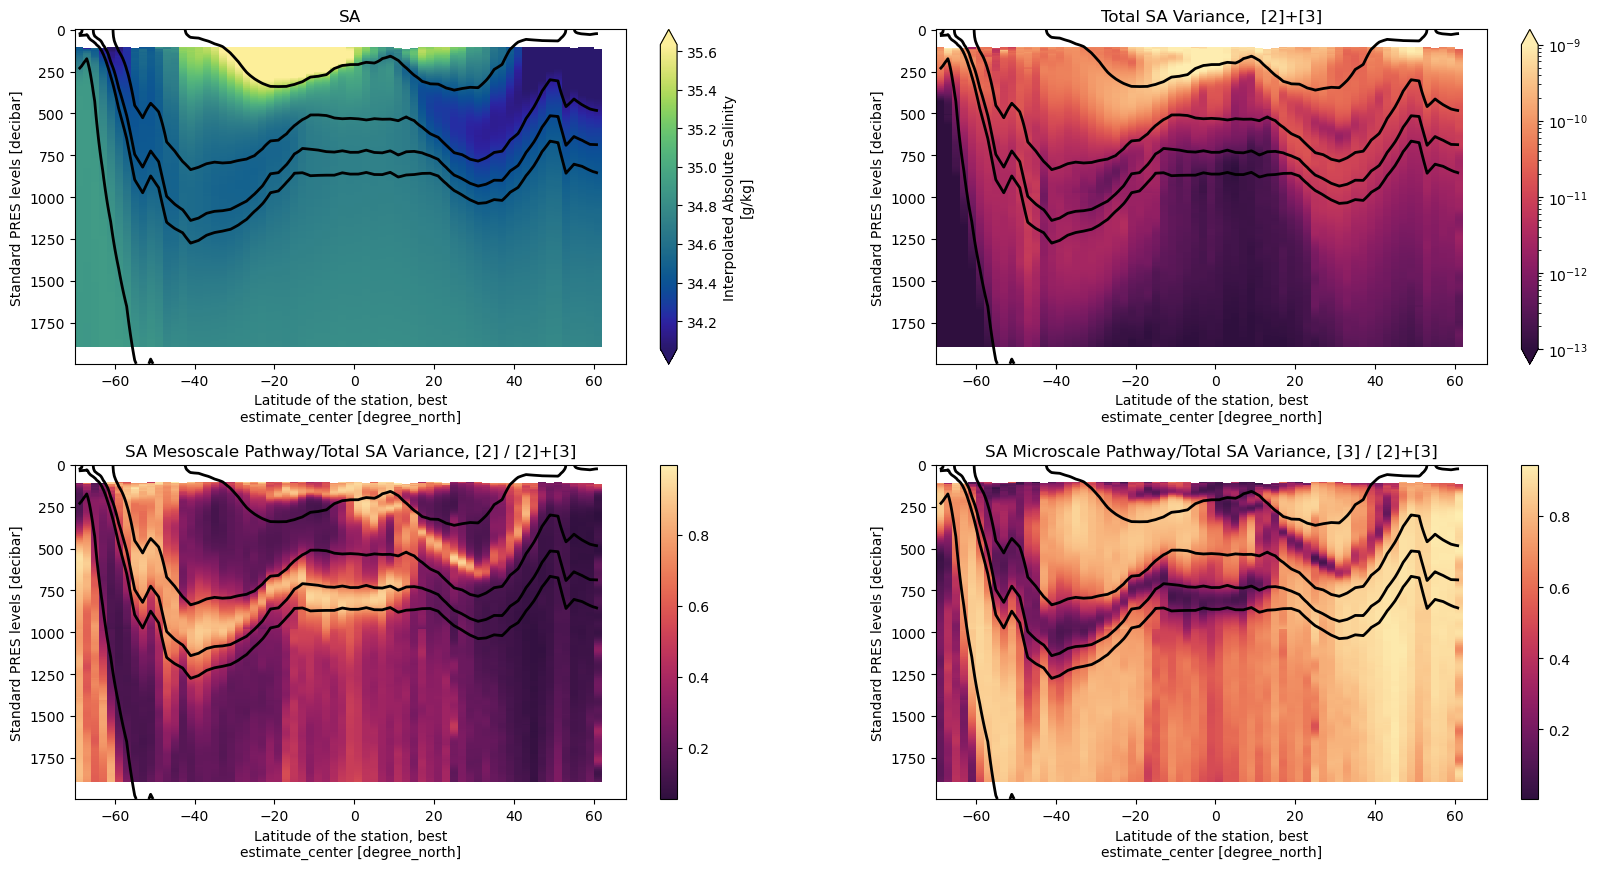

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(221)
sa_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.haline, robust=True)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(222)
sa_tot_binned.plot(x='LATITUDE_bins', y=y, norm=sarat_norm, cmap=rat_cmap)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('Total SA Variance,  [2]+[3]')

plt.subplot(223)
sa_2rat_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.matter_r)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('SA Mesoscale Pathway/Total SA Variance, [2] / [2]+[3]')

plt.subplot(224)
sa_3rat_binned.plot(x='LATITUDE_bins', y=y, cmap=cmo.matter_r)
SIG0_binned.plot.contour(x='LATITUDE_bins', y='PRES_INTERPOLATED', levels=levels, colors='k', linewidths=2)
plt.gca().invert_yaxis()
plt.title('SA Microscale Pathway/Total SA Variance, [3] / [2]+[3]')

plt.subplots_adjust(hspace=0.3, wspace=0.25)

# 2D Histograms

In [29]:
bins = 100

x1 = ct_tot.where(ds.sample_rate<sample_max)
y1 = ct_2.where(ds.sample_rate<sample_max)
x1 = x1.where(x1 > 0, 10000).rename('x1')
y1 = y1.where(y1 > 0, 10000).rename('y1')
x1_bins = np.logspace(np.log10(x1.min().values), np.log10(x1.max().values), bins)
y1_bins = np.logspace(np.log10(y1.min().values), np.log10(y1.max().values), bins)

x2 = x1
y2 = ct_2rat.where(ds.sample_rate<sample_max).rename('y2')
x2_bins = x1_bins
y2_bins = np.linspace(y2.min().values, y2.max().values, bins)

x3 = sa_tot.where(ds.sample_rate<sample_max)
y3 = sa_2.where(ds.sample_rate<sample_max)
x3 = x3.where(x3 > 0, 10000).rename('x3')
y3 = y3.where(y3 > 0, 10000).rename('y3')
x3_bins = np.logspace(np.log10(x3.min().values), np.log10(x3.max().values), bins)
y3_bins = np.logspace(np.log10(y3.min().values), np.log10(y3.max().values), bins)

x4 = x3
y4 = sa_2rat.where(ds.sample_rate<sample_max).rename('y4')
x4_bins = x3_bins
y4_bins = np.linspace(y4.min().values, y4.max().values, bins)

In [46]:
var_start = 100
var_end   = 5*10e4
var_norm  = colors.LogNorm(vmin=var_start, vmax=var_end)
var_cmap  = cmo.dense

rat_start = 1e1
rat_end   = 2*1e4
rat_norm  = colors.LogNorm(vmin=rat_start, vmax=rat_end)
rat_cmap  = cmo.dense

Text(0.5, 1.0, 'SA: Total Variance vs Mesoscale Variance Ratio')

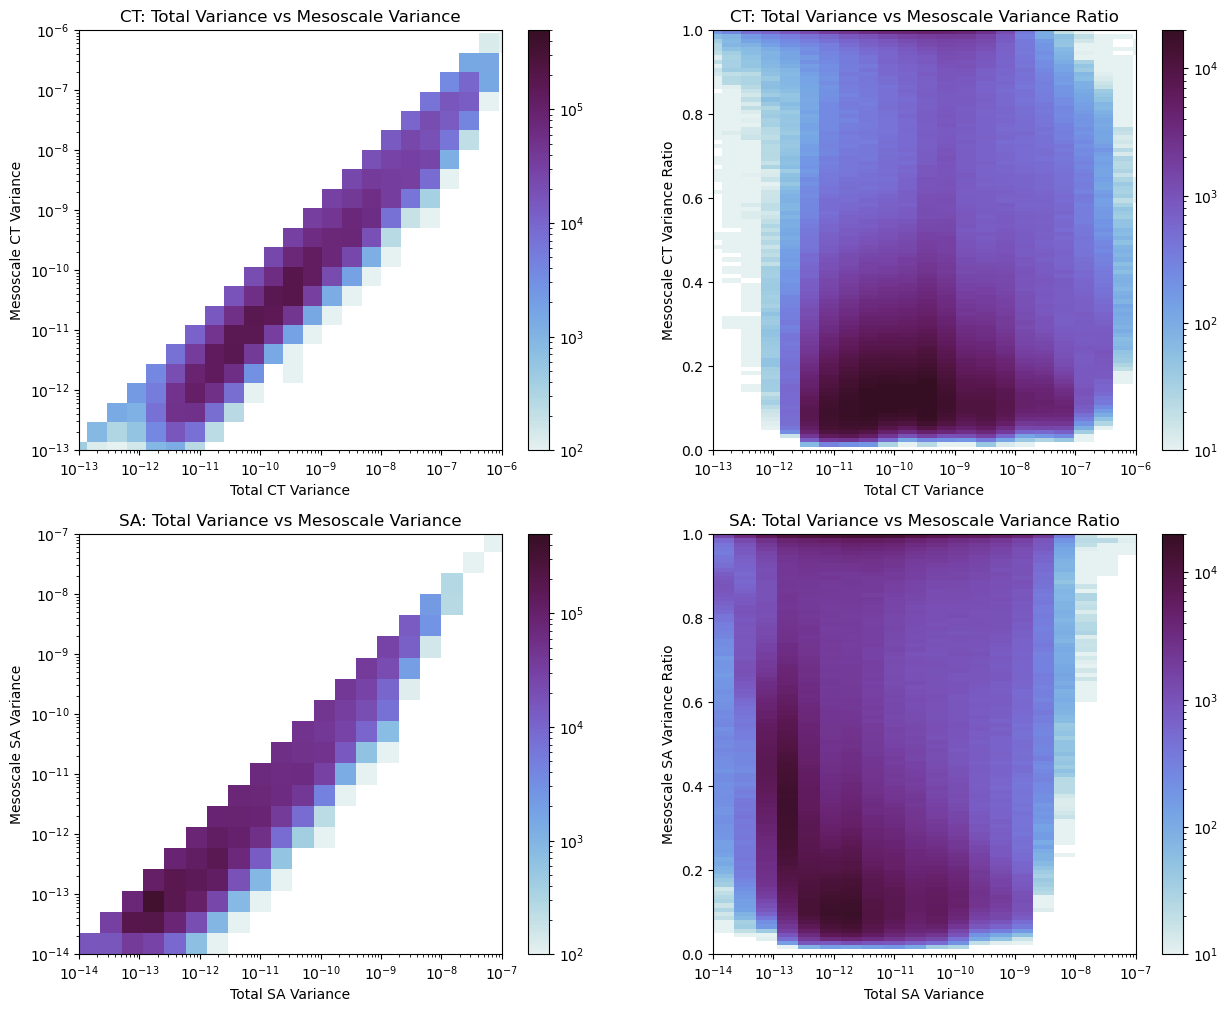

In [47]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plot1 = histogram(x1, y1, bins=[x1_bins, y1_bins])
plt.pcolormesh(x1_bins, y1_bins, plot1.transpose(), norm=var_norm, cmap=var_cmap)
plt.colorbar(label='')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10e-14, 10e-7)
plt.ylim(10e-14, 10e-7)
plt.xlabel('Total CT Variance')
plt.ylabel('Mesoscale CT Variance')
plt.title('CT: Total Variance vs Mesoscale Variance')

plt.subplot(222)
plot2 = histogram(x2, y2, bins=[x2_bins, y2_bins])
plt.pcolormesh(x2_bins, y2_bins, plot2.transpose(), norm=rat_norm, cmap=rat_cmap)
plt.colorbar(label='')
plt.xscale('log')
plt.xlim(10e-14, 10e-7)
plt.ylim(0,1)
plt.xlabel('Total CT Variance')
plt.ylabel('Mesoscale CT Variance Ratio')
plt.title('CT: Total Variance vs Mesoscale Variance Ratio')

plt.subplot(223)
plot3 = histogram(x3, y3, bins=[x3_bins, y3_bins])
plt.pcolormesh(x3_bins, y3_bins, plot3.transpose(), norm=var_norm, cmap=var_cmap)
plt.colorbar(label='')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10e-15, 10e-8)
plt.ylim(10e-15, 10e-8)
plt.xlabel('Total SA Variance')
plt.ylabel('Mesoscale SA Variance')
plt.title('SA: Total Variance vs Mesoscale Variance')

plt.subplot(224)
plot4 = histogram(x4, y4, bins=[x4_bins, y4_bins])
plt.pcolormesh(x4_bins, y4_bins, plot4.transpose(), norm=rat_norm, cmap=rat_cmap)
plt.colorbar(label='')
plt.xscale('log')
plt.xlim(10e-15, 10e-8)
plt.ylim(0,1)
plt.xlabel('Total SA Variance')
plt.ylabel('Mesoscale SA Variance Ratio')
plt.title('SA: Total Variance vs Mesoscale Variance Ratio')

# T-S Diagrams

In [32]:
sbins = np.arange(ds.SA.min(),ds.SA.max(), 0.025)
tbins = np.arange(ds.CT.min(),ds.CT.max(), 0.1)

s = ds.SA.where(ds.sample_rate<sample_max)
t = ds.CT.where(ds.sample_rate<sample_max)

/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'T-S Diagram, by # of points')

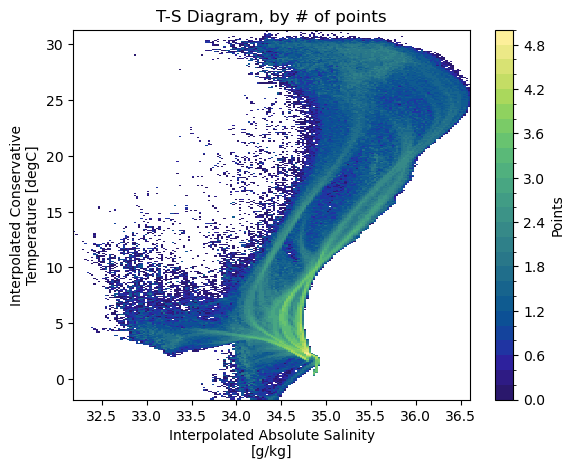

In [33]:
# histogram of number of data points
hTS = histogram(s.where(ds.sample_rate<sample_max), t.where(ds.sample_rate<sample_max), bins=[sbins, tbins])
np.log10(hTS.T).plot(levels=31,cbar_kwargs={'label': 'Points'},cmap=cmo.haline)
plt.title('T-S Diagram, by # of points')

/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'T-S Diagram, by volume of water')

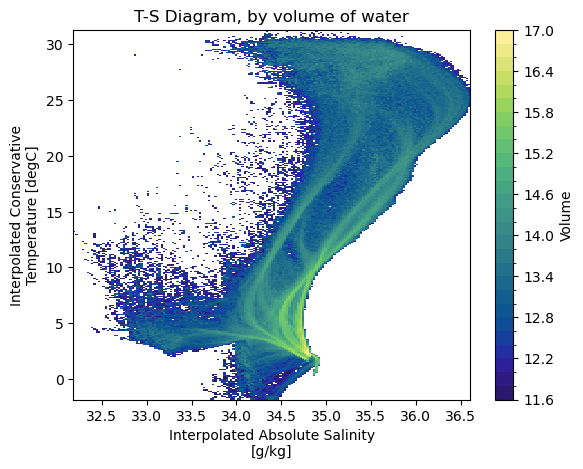

In [34]:
# histogram of number of data points weighted by volume resolution
# Note that depth is a non-uniform axis

# Create a dz variable
dz = np.diff(ds.PRES_INTERPOLATED)
dz =np.insert(dz, 0, dz[0])
dz = xr.DataArray(dz, coords= {'lev':ds.PRES_INTERPOLATED}, dims='PRES_INTERPOLATED')

# weight by volume of grid cell (resolution = 5degree, 1degree=110km)
dVol = dz * (5*110e3) * (5*110e3*np.cos(ds.LATITUDE*np.pi/180))

# Note: The weights are automatically broadcast to the right size
hTSw = histogram(ds.SA.where(ds.sample_rate<sample_max), ds.CT.where(ds.sample_rate<sample_max), bins=[sbins, tbins], weights=dVol)
np.log10(hTSw.T).plot(levels=31, cmap=cmo.haline,cbar_kwargs={'label': 'Volume'})
plt.title('T-S Diagram, by volume of water')

In [35]:
lat_start = -70
lat_end   = 70
lat_norm  = colors.Normalize(vmin=lat_start, vmax=lat_end)
lat_cmap  = cmo.balance

depth_start = 0
depth_end   = 2000
depth_norm  = colors.Normalize(vmin=depth_start, vmax=depth_end)
depth_cmap  = cmo.gray_r

In [36]:
ctvar_start = 10**-11
ctvar_end   = 10**-6
ctvar_norm  = colors.LogNorm(vmin=ctvar_start, vmax=ctvar_end)
ctvar_cmap  = cmo.matter_r

savar_start = 10**-12
savar_end   = 10**-8
savar_norm  = colors.LogNorm(vmin=savar_start, vmax=savar_end)
savar_cmap  = cmo.matter_r

Text(0.5, 1.0, 'T-S Diagram, by SA variance')

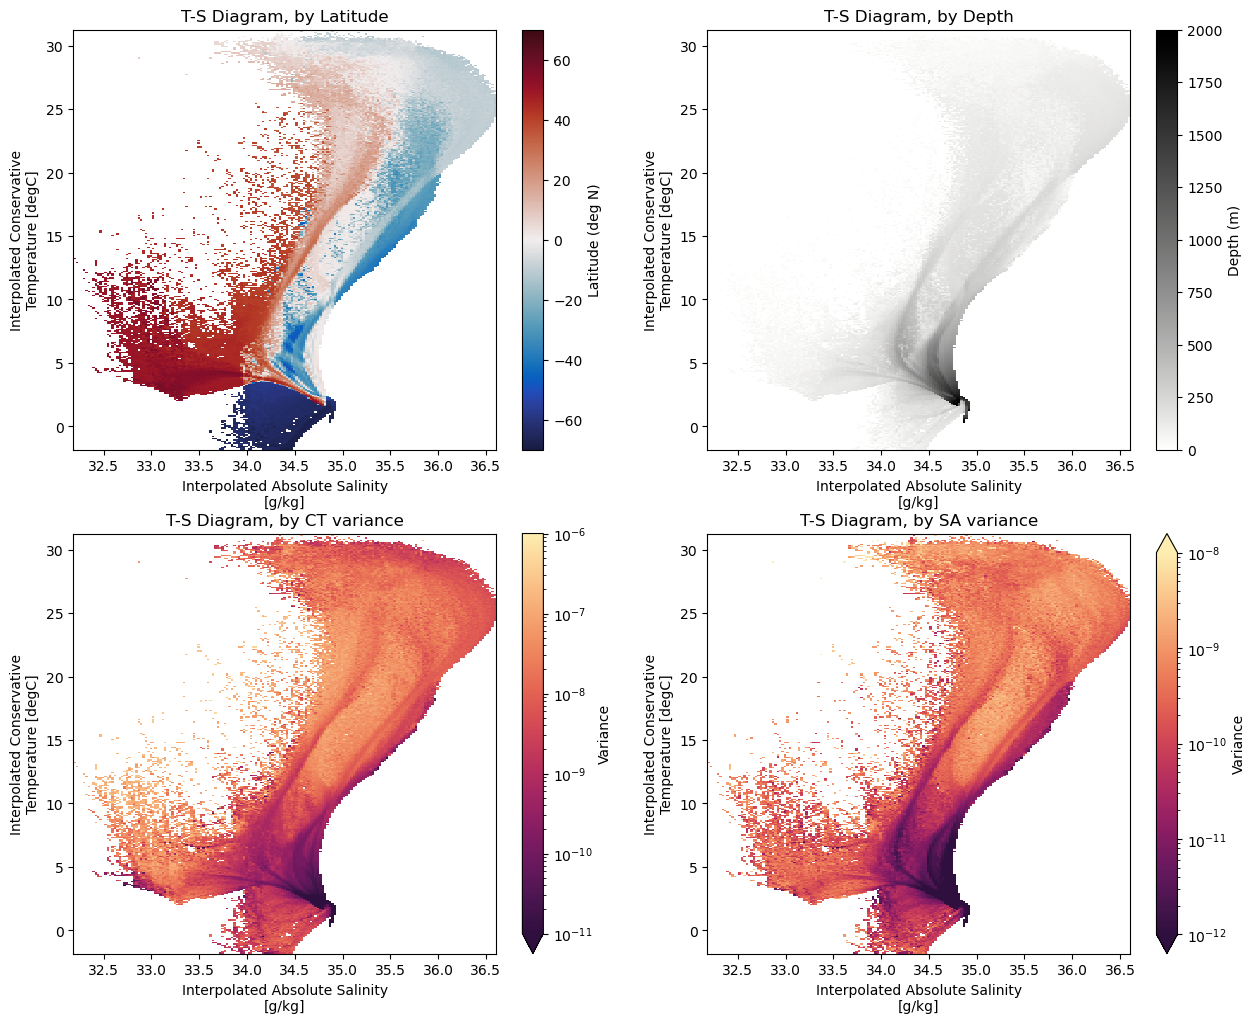

In [37]:
plt.figure(figsize=(15,12))

plt.subplot(221)
lat = ds.LATITUDE
hTS_lat = (histogram(s.where(~np.isnan(lat)),
                   t.where(~np.isnan(lat)),
                   bins=[sbins, tbins],
                   weights=lat.where(~np.isnan(lat))*dVol)/
                histogram(s.where(~np.isnan(lat)),
                          t.where(~np.isnan(lat)),
                          bins=[sbins, tbins],
                          weights=dVol))
(hTS_lat.T).plot(norm=lat_norm, cmap=lat_cmap,cbar_kwargs={'label': 'Latitude (deg N)'})
plt.title('T-S Diagram, by Latitude')

plt.subplot(222)
depth = ds.PRES_INTERPOLATED
hTS_depth = (histogram(s.where(~np.isnan(depth)),
                   t.where(~np.isnan(depth)),
                   bins=[sbins, tbins],
                   weights=depth.where(~np.isnan(depth))*dVol)/
                histogram(s.where(~np.isnan(depth)),
                          t.where(~np.isnan(depth)),
                          bins=[sbins, tbins],
                          weights=dVol))
(hTS_depth.T).plot(norm=depth_norm, cmap=depth_cmap,cbar_kwargs={'label': 'Depth (m)'})
plt.title('T-S Diagram, by Depth')

plt.subplot(223)
ctvar = ct_2
hTS_ctvar = (histogram(s.where(~np.isnan(ctvar)),
                   t.where(~np.isnan(ctvar)),
                   bins=[sbins, tbins],
                   weights=ctvar.where(~np.isnan(ctvar))*dVol)/
                histogram(s.where(~np.isnan(ctvar)),
                          t.where(~np.isnan(ctvar)),
                          bins=[sbins, tbins],
                          weights=dVol))
(hTS_ctvar.T).plot(norm=ctvar_norm, cmap=ctvar_cmap,cbar_kwargs={'label': 'Variance'})
plt.title('T-S Diagram, by CT variance')

plt.subplot(224)
savar = sa_2
hTS_savar = (histogram(s.where(~np.isnan(savar)),
                   t.where(~np.isnan(savar)),
                   bins=[sbins, tbins],
                   weights=savar.where(~np.isnan(savar))*dVol)/
                histogram(s.where(~np.isnan(savar)),
                          t.where(~np.isnan(savar)),
                          bins=[sbins, tbins],
                          weights=dVol))
(hTS_savar.T).plot(norm=savar_norm, cmap=savar_cmap,cbar_kwargs={'label': 'Variance'})
plt.title('T-S Diagram, by SA variance')